In [49]:
import numpy as np

In [50]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

In [51]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [52]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [53]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

In [54]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

In [56]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            output = predict(network, x)
            error += loss(y, output)
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

1/10000, error=1.2593039508823554
2/10000, error=1.0832365559839614
3/10000, error=1.0506974707630492
4/10000, error=1.0116599515320084
5/10000, error=0.857689946505253
6/10000, error=0.41472324203800126
7/10000, error=0.36498602179638073
8/10000, error=0.33444737997003415
9/10000, error=0.3075748906669831
10/10000, error=0.28749899351133024
11/10000, error=0.2726921271273793
12/10000, error=0.26074775551159324
13/10000, error=0.2506270150424169
14/10000, error=0.24191349327320777
15/10000, error=0.23435922816996846
16/10000, error=0.2277782979195807
17/10000, error=0.2220166029135376
18/10000, error=0.21693907288832548
19/10000, error=0.21242385702248695
20/10000, error=0.20835958789950582
21/10000, error=0.20464361635072234
22/10000, error=0.20118017900759097
23/10000, error=0.19787806154140086
24/10000, error=0.19464758935909904
25/10000, error=0.19139684798847093
26/10000, error=0.188027013535396
27/10000, error=0.18442664690901084
28/10000, error=0.18046488296643676
29/10000, erro

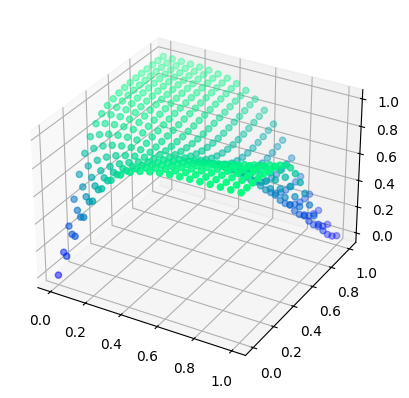

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

# train
train(network, mse, mse_prime, X, Y, epochs=10000, learning_rate=0.1)

# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()